<a href="https://colab.research.google.com/github/marinaefstratiou/ml_notebooks/blob/main/CIFAR_10_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt

**Configuring a TPU to speed up training**

In [3]:
try:
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.TPUStrategy(resolver)
except ValueError:
  print("Could not connect to TPU")
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# Display dataset information
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

170498071/170498071 [==============================] - 2s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


array([[[255, 255, 255],
        [253, 253, 253],
        [253, 253, 253],
        ...,
        [253, 253, 253],
        [253, 253, 253],
        [253, 253, 253]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       ...,

       [[113, 120, 112],
        [111, 118, 111],
        [105, 112, 106],
        ...,
        [ 72,  81,  80],
        [ 72,  80,  79],
        [ 72,  80,  79]],

       [[111, 118, 110],
        [104, 111, 104],
        [ 99, 106,  98],
        ...,
        [ 68,  75,  73],
        [ 70,  76,  75],
        [ 78,  84,  82]],

       [[106, 113, 105],
        [ 99, 106,  98],
        [ 95, 102,  94],
        ...,
        [ 78,  85,  83],
        [ 79,  85,  83],
        [ 80,  86,  84]]], dtype=uint8)
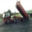

In [5]:
x_train[2]

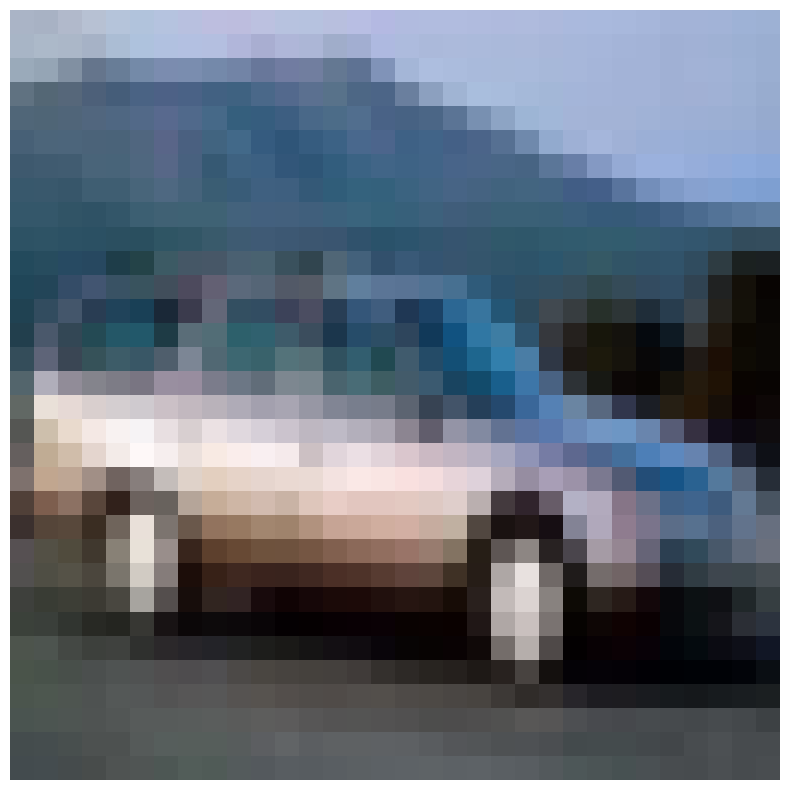

In [6]:
# Display the image with larger visualization
plt.figure(figsize=(10, 10))  # Adjust the figure size as needed
plt.imshow(x_train[4])
plt.axis('off')
plt.show()

In [5]:
cifar10

<module 'keras.api._v2.keras.datasets.cifar10' from '/usr/local/lib/python3.10/dist-packages/keras/api/_v2/keras/datasets/cifar10/__init__.py'>

In [7]:
label_names=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']


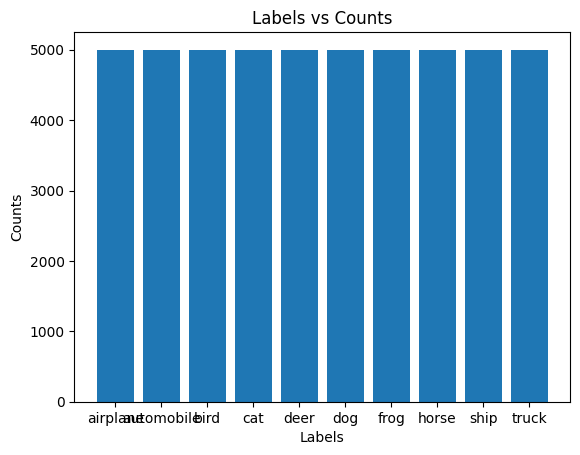

In [8]:
#make a histogram that has y axis the counts and x axis the labels
label_counts = {}
i = {i for i in label_names}
counts=np.zeros((10)) #number of labels
counts[0]
for i in y_train:
  counts[i]+=1
counts

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the bars
ax.bar(label_names, counts)

# Customize the bar plot
ax.set_title('Labels vs Counts')
ax.set_xlabel('Labels')
ax.set_ylabel('Counts')

# Show the plot
plt.show()


In [14]:
#Create the model

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications import VGG16

def make_mymodel():
  return Sequential([
      tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32,32,3)), #3x3 pixel size
      tf.keras.layers.MaxPooling2D(2,2), # 2x2 pool size
      tf.keras.layers.Conv2D(32, (3, 3), activation='relu'), #3x3 pixel size
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(32, (3, 3), activation='relu'), #3x3 pixel size
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(), #based on the sized of images because "Dense" is for 1D arrays
      tf.keras.layers.Dense(units=32, activation='relu'), #relu for internal layers
      tf.keras.layers.Dense(units=16, activation='relu'),
      tf.keras.layers.Dense(units=10, activation='softmax'),  #because this is a multi-class classification problem
  ])


# Load the pre-trained VGG16 model
def make_VGG16():
  return VGG16(include_top=False, input_shape=(32,32, 3))

with strategy.scope():
  model = make_mymodel()
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 32)          9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 32)         0

In [15]:
#Specify cost and loss
#will use Adam optimizer for this
#Adam: provides adaptive learning, rates, momentum (accelerates gradients in the right direction) and bias correction
from tensorflow.keras.losses import SparseCategoricalCrossentropy
##do not use from_logits = True for the compile because
#from_logits=True, the output of your model should be raw logits, not probabilities
#either use softmax or from_logits = True
with strategy.scope():
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate= 1e-3), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [16]:
#Train on data to minimize loss
#epochs: During each epoch, the model sees the entire dataset, usually in batches,
#to update its parameters (weights and biases) via optimization algorithms
#like stochastic gradient descent (SGD) or Adam.
model.fit(x_train,y_train, epochs=10, batch_size=100)

Epoch 1/10
500/500 [==============================] - 13s 16ms/step - loss: 2.3598 - accuracy: 0.2278
Epoch 2/10
500/500 [==============================] - 8s 15ms/step - loss: 1.7157 - accuracy: 0.3631
Epoch 3/10
500/500 [==============================] - 8s 15ms/step - loss: 1.5506 - accuracy: 0.4287
Epoch 4/10
500/500 [==============================] - 8s 15ms/step - loss: 1.4491 - accuracy: 0.4705
Epoch 5/10
500/500 [==============================] - 7s 15ms/step - loss: 1.3687 - accuracy: 0.5056
Epoch 6/10
500/500 [==============================] - 8s 16ms/step - loss: 1.2902 - accuracy: 0.5350
Epoch 7/10
500/500 [==============================] - 8s 15ms/step - loss: 1.2376 - accuracy: 0.5548
Epoch 8/10
500/500 [==============================] - 8s 16ms/step - loss: 1.1867 - accuracy: 0.5743
Epoch 9/10
500/500 [==============================] - 8s 16ms/step - loss: 1.1362 - accuracy: 0.5953
Epoch 10/10
500/500 [==============================] - 8s 15ms/step - loss: 1.1047 - accur

In [ ]:
# Convert the evaluation data to a TensorFlow dataset object or NumPy arrays
evaluation_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test, label_names))

# Ensure the evaluation dataset is batched and shuffled if needed
evaluation_dataset = evaluation_dataset.batch(batch_size=20)

# Evaluate the model on the evaluation dataset
loss, accuracy = model.evaluate(x_test, y_test)

# Print the evaluation results
print("Loss:", loss)
print("Accuracy:", accuracy)